## Figure 3A-D

## Helper codes: run below cells before any of the other cells. 

In [1]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches

from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mode, sem, spearmanr, pearsonr
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from itertools import combinations, product, permutations
import math

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.multiclass import OneVsOneClassifier
from sklearn.manifold import Isomap

import time

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

In [2]:
# loading variables

# openscope
with open('SVM_prerequisite_variables.pickle', 'rb') as f:
    SVM_prerequisite_variables = pickle.load(f)
    
    list_rate_w1 = SVM_prerequisite_variables['list_rate_w1'].copy()
    list_stm_w1 = SVM_prerequisite_variables['list_stm_w1'].copy()
    list_neu_loc = SVM_prerequisite_variables['list_neu_loc'].copy()
    list_wfdur = SVM_prerequisite_variables['list_wfdur'].copy()
    list_slopes_an_loglog = SVM_prerequisite_variables['list_slopes_an_loglog'].copy()
    list_slopes_an_loglog_12 = SVM_prerequisite_variables['list_slopes_an_loglog_12'].copy()

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()
    sess_inds_qual_all_dr = resp_matrix_ep_RS_all['sess_inds_qual_all_dr'].copy()

In [3]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [4]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [6]:
# Function to compute cosine similarity
def cos_sim(x, y):
    # x and y are 1D vectors

    dot_xy = np.dot(x, y)
    norm_x, norm_y = np.linalg.norm(x), np.linalg.norm(y)

    cos_sim = dot_xy / (norm_x * norm_y)

    return cos_sim

# def cos_sim2(x, y):
#     # x and y are 1D vectors

#     return np.dot(normalize(np.reshape(x, (1, -1))), normalize(np.reshape(y, (-1, 1))))

In [7]:
# Function to compute orthogonal & parallel distance
def compute_orth_par_dist(manifold_name1, manifold_name2, rate_12, rate_sorted_mean_coll):
    mean_vector = rate_sorted_mean_coll.loc[:, manifold_name2] - rate_sorted_mean_coll.loc[:, manifold_name1] # mean vector
    mat1 = rate_12.loc[:, manifold_name1].sub(rate_sorted_mean_coll.loc[:, manifold_name1], axis=0) # trial vector
    mat_orth1 = np.array(mat1.apply(lambda x : np.dot(x, mean_vector), axis=0).div(np.dot(mean_vector, mean_vector)))[:, np.newaxis].T * np.array(mean_vector)[:, np.newaxis]
    mat_par1 = mat_orth1 - mat1

    return mat_orth1, mat_par1

## Codes for figures

## Figure 3A

session index: 6


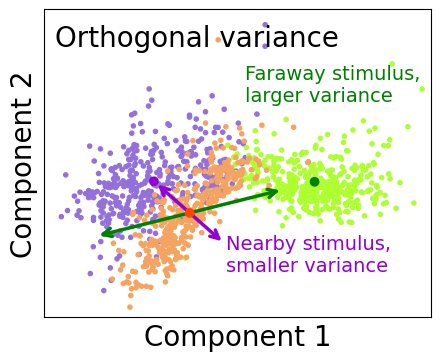

In [8]:
# wcfg1 isomap (RRneuron) (orthogonal variance figure)
    
num_trials = 400 

# Iterate over all sessions

for sess_ind, (rate_all, stm, neu_loc, wfdur) in enumerate(zip(list_rate_w1, list_stm_w1, list_neu_loc, list_wfdur)):
    
    if sess_ind == 6:
    
        print(f'session index: {sess_ind}')

        # rate_all transposition
        rate_all = rate_all.T.copy()

        # Extract V1 neurons
        ser_neu_loc = pd.Series(neu_loc)
        list_visp = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm')]
        rate = rate_all[[all(bools) for bools in zip(*list_visp)]].copy()
        # print(rate.shape[0])
        # list_visp_rs = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm'), (wfdur >= 0.4)]
        # rate = rate_all[[all(bools) for bools in zip(*list_visp_rs)]].copy()
        # print(np.sum([all(bools) for bools in zip(*list_visp_rs)]))

        # Multiply by delta t to convert to spike counts
        rate = rate * 0.4
        
        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
        dict_trial_type = {0: 'Blank', 1: 'X', 2:'Tc1', 3: 'Ic1', 4: 'Lc1', 5:'Tc2', 6: 'Lc2', 7: 'Ic2', \
            8: 'Ire1', 9: 'Ire2', 10: 'Tre1', 11: 'Tre2', 12: 'Xre1', 13: 'Xre2', 14: 'BR_in', 15: 'BL_in', \
                16: 'TL_in', 17: 'TR_in', 18: 'BR_out', 19: 'BL_out', 20: 'TL_out', 21: 'TR_out'}
        
        # Create label array for all stimuli
        label = []
        for i in stm:
            for trial_type_num in dict_trial_type:
                if i == trial_type_num:
                    label.append(dict_trial_type[trial_type_num])
        label = np.array(label)

        # convert to dataframe
        rate = pd.DataFrame(rate, columns=label)

        # sort trials based on stimuli
        rate_sorted = rate.sort_index(axis=1)
        label_sorted = np.array(sorted(label))

        # Create a counting dictionary for each stimulus 
        all_label_unique, all_label_counts = np.unique(label, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Extract stimuli having 400 repeats (trials)
        rate_sorted = rate_sorted.loc[:, all_label_unique[all_label_counts == 400]].copy()
        all_label_unique, all_label_counts = np.unique(rate_sorted.columns, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(label_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted)

        # isomap
        n_components = 2 # target number of dimensions
        # n_components = rate_sorted.shape[0] # target number of dimensions
        n_neighbors = 5 # number of neighbors

        isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)

        # rate_plus_mean = pd.concat([rate_sorted, rate_sorted_mean_coll.loc[:, ['Ic1', 'Lc1']]], axis=1) 
        # rate_plus_mean_isomap = isomap.fit_transform(rate_plus_mean.T).T # isomap including centroids
        
        rate_isomap = pd.DataFrame(isomap.fit_transform(rate_sorted.T).T, columns=rate_sorted.columns) # isomap without centroids 
        rate_plus_mean_isomap, _ = compute_mean_var_trial_collapse(label_cnt_dict, rate_isomap) 

        bool_Ic1 = rate_isomap.columns == 'Ic1'
        bool_Lc1 = rate_isomap.columns == 'Lc1'
        bool_Tre2 = rate_isomap.columns == 'Tre2'
        bool_rest = ~np.isin(rate_isomap.columns, ['Ic1', 'Lc1', 'Tre2'])

        # color list & label list
        list_colors = np.repeat(np.array(['gray'], dtype=object), rate_isomap.shape[1])
        list_colors[bool_Ic1] = 'greenyellow'
        list_colors[bool_Lc1] = 'sandybrown'
        list_colors[bool_Tre2] = 'mediumpurple'
        
        rgba_colors = np.array([mcolors.to_rgba(color, alpha=0.2) if color == 'gray' else mcolors.to_rgba(color) for color in list_colors])
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        # trials
        # ax.scatter(rate_isomap.iloc[0, bool_rest], rate_isomap.iloc[1, bool_rest], marker='.', color=rgba_colors[bool_rest], zorder=1)
        ax.scatter(rate_isomap.iloc[0, bool_Tre2], rate_isomap.iloc[1, bool_Tre2], marker='.', color=rgba_colors[bool_Tre2], zorder=1)
        ax.scatter(rate_isomap.iloc[0, bool_Ic1], rate_isomap.iloc[1, bool_Ic1], marker='.', color=rgba_colors[bool_Ic1], zorder=1)
        ax.scatter(rate_isomap.iloc[0, bool_Lc1], rate_isomap.iloc[1, bool_Lc1], marker='.', color=rgba_colors[bool_Lc1], zorder=1)

        # mean points
        ax.scatter(rate_plus_mean_isomap.loc[0, ['Ic1', 'Lc1', 'Tre2']], rate_plus_mean_isomap.loc[1, ['Ic1', 'Lc1', 'Tre2']], marker='o', color=['green', 'orangered', 'darkviolet'], zorder=3) 

        # draw orthogonal variance

        # against Ic1
        slope_mean = (rate_plus_mean_isomap.loc[1, 'Ic1']-rate_plus_mean_isomap.loc[1, 'Lc1']) / (rate_plus_mean_isomap.loc[0, 'Ic1']-rate_plus_mean_isomap.loc[0, 'Lc1'])
        scaling_c = 60
        Lc1_mean = rate_plus_mean_isomap.loc[:, 'Lc1'].copy()

        start_Ic1 = (Lc1_mean[0] - scaling_c, Lc1_mean[1] - scaling_c*slope_mean)
        end_Ic1 = (Lc1_mean[0] + scaling_c, Lc1_mean[1] + scaling_c*slope_mean)
        arrow_Ic1 = patches.FancyArrowPatch(start_Ic1, end_Ic1, arrowstyle="<->",
                                            mutation_scale=15,  # Size of arrowheads
                                            color='green', linewidth=2.5, zorder=2, label='orthogonal variance')
        ax.add_patch(arrow_Ic1)

        # against Tre2
        slope_mean = (rate_plus_mean_isomap.loc[1, 'Tre2']-rate_plus_mean_isomap.loc[1, 'Lc1']) / (rate_plus_mean_isomap.loc[0, 'Tre2']-rate_plus_mean_isomap.loc[0, 'Lc1'])
        scaling_c = 22
        Lc1_mean = rate_plus_mean_isomap.loc[:, 'Lc1'].copy()

        start_Tre2 = (Lc1_mean[0] - scaling_c, Lc1_mean[1] - scaling_c*slope_mean)
        end_Tre2 = (Lc1_mean[0] + scaling_c, Lc1_mean[1] + scaling_c*slope_mean)
        arrow_Tre2 = patches.FancyArrowPatch(start_Tre2, end_Tre2, arrowstyle="<->",
                                            mutation_scale=15,  # Size of arrowheads
                                            color='darkviolet', linewidth=2.5, zorder=2, label='orthogonal variance')
        ax.add_patch(arrow_Tre2)

        ax.annotate(f'Orthogonal variance', xy=(0.03, 0.88), xycoords='axes fraction', fontsize=20, color='k')
        ax.annotate(f'Faraway stimulus,\nlarger variance', xy=(0.52, 0.7), xycoords='axes fraction', fontsize=14, color='green')
        ax.annotate(f'Nearby stimulus,\nsmaller variance', xy=(0.47, 0.15), xycoords='axes fraction', fontsize=14, color='darkviolet')

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        ax.set_xlim([-130, 130]) # with rest points
        ax.set_ylim([-80, 150])
        ax.set_xlim([-110, 140]) # without rest points
        ax.set_ylim([-60, 60])
        # ax.set_aspect('equal')
        ax.set_xticks([]) # remove ticks and label
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        # ax.legend(loc='lower left', prop={'size': 10.5})

        plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_schematic.svg', bbox_inches='tight')
        plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_schematic.png', dpi=300, bbox_inches='tight')
        plt.show()

In [9]:
# # ABO Neuropixels mean similarity vs. orthogonal variance (as-is) (all neurons) (~30 min)
# print('ABO Neuropixels mean similarity vs. orthogonal variance (as-is)\n')

# num_sess = 32
# num_trial_types = 119

# # Iterate over all sessions

# list_mean_sim2_ABO_one_tt = np.zeros((num_sess, num_trial_types, num_trial_types-1)) # permutation of number of stimuli
# list_orthopar2_ABO_one_tt = np.zeros((num_sess, num_trial_types, num_trial_types-1, 2)) # ortho, par
# list_tot_var2_ABO_one_tt = np.zeros((num_sess, num_trial_types, num_trial_types-1, 2))
# for sess_ind in range(num_sess):
#     print(f'sess_ind: {sess_ind}')

#     rate = list_rate_all[sess_ind].sort_index(axis=1)
#     stm = rate.columns.copy()

#     # Multiply by delta t to convert to spike counts
#     rate = rate * 0.25

#     # Create a counting dictionary for each stimulus
#     all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
#     stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

#     # Compute mean & variance for each stimulus
#     rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate)
#     rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate)

#     # concatenate centroids of all stimuli
#     rate_plus_mean = pd.concat([rate, rate_sorted_mean_coll], axis=1)

#     # Compute geodesic distance matrix
#     n_components = 1 # target number of dimensions
#     # n_components = rate.shape[0] # target number of dimensions
#     n_neighbors = 5 # number of neighbors

#     isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
#     isomap.fit(rate_plus_mean.T)
#     mean_dist_mat_asis = isomap.dist_matrix_[rate.shape[1]:, rate.shape[1]:].copy() # inter-centroid geodesic distance matrix
        
#     # Iterate over all stimuli (~25 min)
#     list_mean_sim_one_tt = np.zeros((num_trial_types, num_trial_types-1))
#     list_orthopar_one_tt = np.zeros((num_trial_types, num_trial_types-1, 2))
#     list_tot_var_one_tt = np.zeros((num_trial_types, num_trial_types-1, 2))
#     for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
#         bool_not_tt = rate_sorted_mean_coll.columns != trial_type

#         # compute similarity between centroids
#         list_mean_sim_one_tt[trial_type_ind] = mean_dist_mat_asis[trial_type_ind, bool_not_tt].copy()

#         # compute orthogonal variance against partner stimulus manifold
#         for partner_ind, partner_tt in enumerate(rate_sorted_mean_coll.columns[bool_not_tt]):
#             rate_pair = rate.loc[:, [trial_type, partner_tt]].copy()
#             label_cnt_dict_pair = dict(zip(np.unique(rate_pair.columns, return_counts=True)[0], np.unique(rate_pair.columns, return_counts=True)[1]))
#             rate_sorted_mean_coll_pair, rate_sorted_var_coll_pair = compute_mean_var_trial_collapse(label_cnt_dict_pair, rate_pair)

#             mat_orth, mat_par = compute_orth_par_dist(trial_type, partner_tt, rate_pair, rate_sorted_mean_coll_pair)
#             list_orthopar_one_tt[trial_type_ind, partner_ind] = [np.var(np.linalg.norm(mat_orth, axis=0), ddof=1), \
#                                                           np.var(np.linalg.norm(mat_par, axis=0), ddof=1)]
        
#         # compute total variance for normalization
#         list_tot_var_one_tt[trial_type_ind] = rate_sorted_var_coll.loc[:, trial_type].mean()

#     list_mean_sim2_ABO_one_tt[sess_ind] = list_mean_sim_one_tt.copy()
#     list_orthopar2_ABO_one_tt[sess_ind] = list_orthopar_one_tt.copy()
#     list_tot_var2_ABO_one_tt[sess_ind] = list_tot_var_one_tt.copy()

In [10]:
# similarity_type = 'geodesic'
# save_file_name = 'orthopar_ABO_one_tt_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_mean_sim2_ABO_one_tt', 'list_orthopar2_ABO_one_tt', 'list_tot_var2_ABO_one_tt'], \
#                  'list_mean_sim2_ABO_one_tt': list_mean_sim2_ABO_one_tt, 'list_orthopar2_ABO_one_tt': list_orthopar2_ABO_one_tt, 'list_tot_var2_ABO_one_tt': list_tot_var2_ABO_one_tt}, f)

## Figure 3B-D

(30, 119, 118) (30, 119, 118, 3)


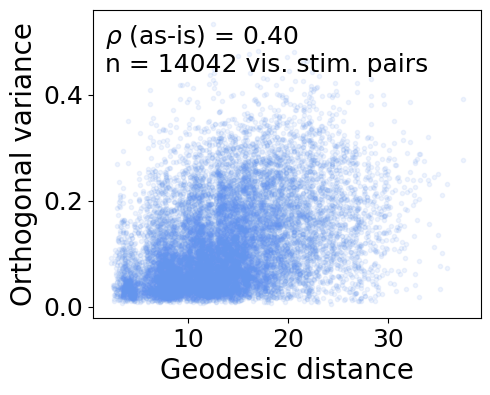

mean r = 0.3313491879447722


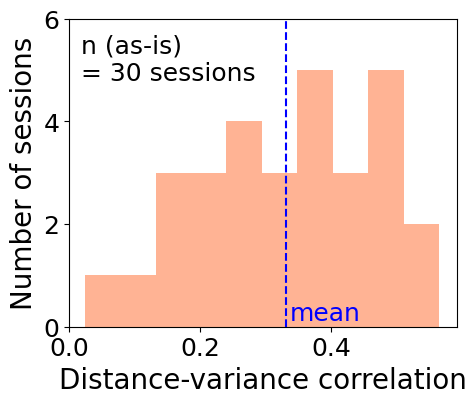

In [9]:
# mean similarity vs. orthogonal variance scatterplot (as-is)

similarity_type = 'geodesic'

save_file_name = 'orthopar_ABO_one_tt_' + similarity_type + '.pickle' # 32 sessions, 119 trial types
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    orthopar_ABO_one_tt = pickle.load(f)

    list_mean_sim2_ABO_one_tt, list_orthopar2_ABO_one_tt, list_tot_var2_ABO_one_tt = \
        orthopar_ABO_one_tt['list_mean_sim2_ABO_one_tt'].copy(), orthopar_ABO_one_tt['list_orthopar2_ABO_one_tt'].copy(), orthopar_ABO_one_tt['list_tot_var2_ABO_one_tt'].copy()

num_sess = 32
num_trial_types = 119

# Exclude low quality sessions (0, 6)
list_mean_sim2_ABO_one_tt = np.concatenate([list_mean_sim2_ABO_one_tt[1:6], list_mean_sim2_ABO_one_tt[7:]], axis=0)
list_orthopar2_ABO_one_tt = np.concatenate([list_orthopar2_ABO_one_tt[1:6], list_orthopar2_ABO_one_tt[7:]], axis=0)
list_tot_var2_ABO_one_tt = np.concatenate([list_tot_var2_ABO_one_tt[1:6], list_tot_var2_ABO_one_tt[7:]], axis=0)
num_sess = list_mean_sim2_ABO_one_tt.shape[0]

# convert total variance from mean to sum
list_num_neurons = np.array([list_rate_all[sess_ind].shape[0] for sess_ind in range(num_sess)])
list_tot_var2_ABO_one_tt = list_tot_var2_ABO_one_tt * list_num_neurons[:, None, None, None]

list_orthopar_ratio2_one_tt = list_orthopar2_ABO_one_tt[:, :, :, 0] / list_orthopar2_ABO_one_tt[:, :, :, 1]
list_orthopar2_ABO_one_tt_norm = list_orthopar2_ABO_one_tt / list_tot_var2_ABO_one_tt # normalized variance
# list_orthopar2_ABO_one_tt_norm = list_orthopar2_ABO_one_tt.copy()
list_orthopar_concat2_ABO_one_tt = np.concatenate([list_orthopar2_ABO_one_tt_norm, list_orthopar_ratio2_one_tt[:, :, :, None]], axis=3) 
print(list_mean_sim2_ABO_one_tt.shape, list_orthopar_concat2_ABO_one_tt.shape)

var_ind = 0

# Plot for each session
# fig, axes = plt.subplots(math.ceil(num_sess/4), 4, figsize=(22, 40))
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

for sess_ind in range(num_sess):
    
    if sess_ind == 5: # spearman
        ax_ind = sess_ind - 5
        # ax_ind = sess_ind
        axes[ax_ind].scatter(list_mean_sim2_ABO_one_tt[sess_ind].flatten(), \
                            list_orthopar_concat2_ABO_one_tt[sess_ind, :, :, var_ind].flatten(), marker='.', color='cornflowerblue', alpha=0.1)

        # axes[ax_ind].set_title(f'As-is', fontsize=19)
        axes[ax_ind].set_xlabel('Geodesic distance', fontsize=20)
        # axes[ax_ind].set_xlabel('Cosine similarity', fontsize=17)
        axes[ax_ind].set_ylabel('Orthogonal variance', fontsize=20)
        # axes[ax_ind].set_xticks(np.arange(0, 50, 10))
        axes[ax_ind].set_yticks(np.arange(0, 0.5, 0.2))
        axes[ax_ind].tick_params('both', labelsize=18)

        corrcoef_sess = spearmanr(list_mean_sim2_ABO_one_tt[sess_ind].flatten(), \
                            list_orthopar_concat2_ABO_one_tt[sess_ind, :, :, var_ind].flatten())[0]
        axes[ax_ind].annotate(f'$\\rho$ (as-is) = {corrcoef_sess:.2f}', xy=(0.03, 0.89), xycoords='axes fraction', fontsize=18)
        axes[ax_ind].annotate(f'n = {len(list_mean_sim2_ABO_one_tt[sess_ind].flatten())} vis. stim. pairs', xy=(0.03, 0.8), xycoords='axes fraction', fontsize=18)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist_scatter.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# correlation for each session
list_corrcoef_sess_ABO_one_tt_asis = np.zeros(num_sess) 
for sess_ind in range(num_sess):
    for trial_type_ind in range(num_trial_types):
        
        
        corrcoef_sess_ABO_one_tt = spearmanr(list_mean_sim2_ABO_one_tt[sess_ind].flatten(), \
                    list_orthopar_concat2_ABO_one_tt[sess_ind, :, :, var_ind].flatten())[0]
        list_corrcoef_sess_ABO_one_tt_asis[sess_ind] = corrcoef_sess_ABO_one_tt
        
print(f'mean r = {np.mean(list_corrcoef_sess_ABO_one_tt_asis)}')

# histogram
fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(list_corrcoef_sess_ABO_one_tt_asis, bins=10, color='lightsalmon', histtype='stepfilled', alpha=0.8)
# ax.axvline(0, c='k', linestyle='--', linewidth=2)
ax.axvline(np.mean(list_corrcoef_sess_ABO_one_tt_asis), c='blue', linestyle='--')

ax.set_xlabel('Distance-variance correlation', fontsize=20)
ax.set_ylabel('Number of sessions', fontsize=20)
ax.tick_params('both', labelsize=18)

ax.set_xlim(0, ax.get_xlim()[1])
# ax.set_xlim(0, 0.6)
ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, 7, 2))

ax.annotate(f'n (as-is)\n= {num_sess} sessions', xy=(0.03, 0.8), xycoords='axes fraction', fontsize=18)
width = (np.mean(list_corrcoef_sess_ABO_one_tt_asis)-ax.get_xlim()[0]) / (ax.get_xlim()[1]-ax.get_xlim()[0])
ax.annotate(f'mean', xy=(width+0.01, 0.02), xycoords='axes fraction', color='blue', fontsize=18)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist_histogram.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# # mean similarity vs. orthogonal variance loading (ABO RRneuron)

# similarity_type = 'geodesic'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119

# list_mean_sim3_ABO_one_tt = np.zeros((len(list_target_slopes), num_sess, num_trial_types, num_trial_types-1))
# list_orthopar3_ABO_one_tt = np.zeros((len(list_target_slopes), num_sess, num_trial_types, num_trial_types-1, 2))
# list_tot_var3_ABO_one_tt = np.zeros((len(list_target_slopes), num_sess, num_trial_types, num_trial_types-1, 2))
# for slope_ind, target_slope in enumerate(list_target_slopes):
#     filename = 'meansim_orthopar_ABO_allneu_' + similarity_type + str(slope_ind) + '.pickle'
   
#     with open(filename, "rb") as f:
#         meansim_orthopar_ABO_allneu = pickle.load(f)
        
#         list_mean_sim3_ABO_one_tt[slope_ind] = meansim_orthopar_ABO_allneu['list_mean_sim2_ABO_one_tt'].copy()
#         list_orthopar3_ABO_one_tt[slope_ind] = meansim_orthopar_ABO_allneu['list_orthopar2_ABO_one_tt'].copy()
#         list_tot_var3_ABO_one_tt[slope_ind] = meansim_orthopar_ABO_allneu['list_tot_var2_ABO_one_tt'].copy()

# save_fliename = 'meansim_orthopar_ABO_all_allneu_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_fliename, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_mean_sim3_ABO_one_tt', 'list_orthopar3_ABO_one_tt', 'list_tot_var3_ABO_one_tt'],
#                  'list_mean_sim3_ABO_one_tt': list_mean_sim3_ABO_one_tt, 'list_orthopar3_ABO_one_tt': list_orthopar3_ABO_one_tt, 'list_tot_var3_ABO_one_tt': list_tot_var3_ABO_one_tt}, f)

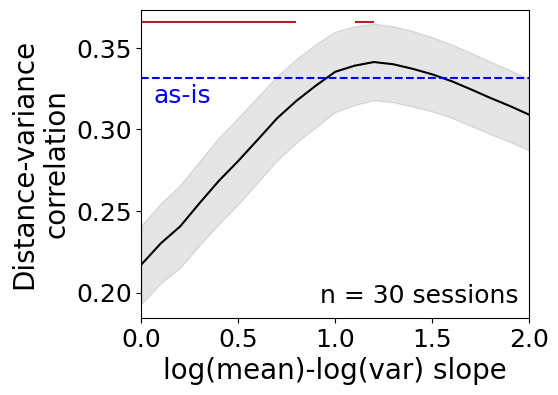

In [12]:
# mean similarity vs. orthogonal variance scatterplot & histogram (ABO RRneuron)

similarity_type = 'geodesic'

save_fliename = 'meansim_orthopar_ABO_all_allneu_' + similarity_type + '.pickle' # geodesic: 32 sessions, 119 trial types
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_fliename, 'rb') as f:
    meansim_orthopar_ABO_all_allneu = pickle.load(f)
    
    list_mean_sim3_ABO_one_tt = meansim_orthopar_ABO_all_allneu['list_mean_sim3_ABO_one_tt'].copy()
    list_orthopar3_ABO_one_tt = meansim_orthopar_ABO_all_allneu['list_orthopar3_ABO_one_tt'].copy()
    list_tot_var3_ABO_one_tt = meansim_orthopar_ABO_all_allneu['list_tot_var3_ABO_one_tt'].copy()
    
list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

num_sess = 32
num_trial_types = 119

# Exclude low quality sessions (0, 6)
list_mean_sim3_ABO_one_tt = np.concatenate([list_mean_sim3_ABO_one_tt[:, 1:6], list_mean_sim3_ABO_one_tt[:, 7:]], axis=1)
list_orthopar3_ABO_one_tt = np.concatenate([list_orthopar3_ABO_one_tt[:, 1:6], list_orthopar3_ABO_one_tt[:, 7:]], axis=1)
list_tot_var3_ABO_one_tt = np.concatenate([list_tot_var3_ABO_one_tt[:, 1:6], list_tot_var3_ABO_one_tt[:, 7:]], axis=1)
num_sess = list_mean_sim3_ABO_one_tt.shape[1]

# convert total variance from mean to sum
list_num_neurons = np.array([list_rate_all[sess_ind].shape[0] for sess_ind in range(num_sess)])
list_tot_var3_ABO_one_tt = list_tot_var3_ABO_one_tt * list_num_neurons[None, :, None, None, None]

list_orthopar_ratio3_ABO_one_tt = list_orthopar3_ABO_one_tt[:, :, :, :, 0] / list_orthopar3_ABO_one_tt[:, :, :, :, 1]
list_orthopar3_ABO_one_tt_norm = list_orthopar3_ABO_one_tt / list_tot_var3_ABO_one_tt # normalized variance
# list_orthopar3_ABO_one_tt_norm = list_orthopar3_ABO_one_tt.copy()
list_orthopar_concat3_ABO_one_tt = np.concatenate([list_orthopar3_ABO_one_tt_norm, list_orthopar_ratio3_ABO_one_tt[:, :, :, :, None]], axis=4) 

# correlation for each session histogram
list_corrcoef_sess_ABO_one_tt2 = np.zeros((len(list_target_slopes), num_sess))
for slope_ind, target_slope in enumerate(list_target_slopes):
    # print(f'target slope = {target_slope:.1f}')

    list_corrcoef_sess_ABO_one_tt = np.zeros(num_sess)
    for sess_ind in range(num_sess):
        corrcoef_sess_ABO_one_tt = spearmanr(list_mean_sim3_ABO_one_tt[slope_ind, sess_ind].flatten(), \
                    list_orthopar_concat3_ABO_one_tt[slope_ind, sess_ind, :, :, 0].flatten())[0]
        list_corrcoef_sess_ABO_one_tt[sess_ind] = corrcoef_sess_ABO_one_tt
    list_corrcoef_sess_ABO_one_tt2[slope_ind] = list_corrcoef_sess_ABO_one_tt.copy()

# Wilcoxon signed-rank test (as-is vs. RRneuron)
list_pvals_corrcoef_RRneuron = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_corrcoef_RRneuron[slope_ind] = list(wilcoxon(list_corrcoef_sess_ABO_one_tt_asis, \
                                                            list_corrcoef_sess_ABO_one_tt2[slope_ind]))[1]
list_pvals_corrcoef_RRneuron = np.array(multipletests(list_pvals_corrcoef_RRneuron, method='holm')[1]) # multiple comparisons correction
list_sig_slopes_corrcoef = list_target_slopes[list_pvals_corrcoef_RRneuron < 0.05].copy()
# print(f'significant slope: {list_sig_slopes_corrcoef}')
    
# correlation mean or median line plot
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_corrcoef = np.mean(list_corrcoef_sess_ABO_one_tt2, axis=1)
list_errs_corrcoef = sem(list_corrcoef_sess_ABO_one_tt2, axis=1)

axes[0].plot(list_target_slopes, list_means_corrcoef, c='k')
axes[0].fill_between(list_target_slopes, list_means_corrcoef-list_errs_corrcoef, \
                     list_means_corrcoef+list_errs_corrcoef, color='k', alpha=0.1)

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
annotate_lineplot_significance(list_sig_slopes_corrcoef, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')

# as-is
axes[0].axhline(np.mean(list_corrcoef_sess_ABO_one_tt_asis), c='blue', linestyle='--', label='as-is')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Distance-variance\ncorrelation', fontsize=20)
axes[0].tick_params('both', labelsize=18)
# axes[0].set_yticks(np.arange(0.15, 0.4, 0.1))
# axes[0].legend(loc='lower left', bbox_to_anchor=(0.01, (np.mean(list_corrcoef_sess_ABO_one_tt_asis)-0.1) / axes[0].get_ylim()[1]), prop={'size': 12})
height = (np.mean(list_corrcoef_sess_ABO_one_tt_asis)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.03, height-0.08), xycoords='axes fraction', fontsize=18, color='blue')
axes[0].annotate(f'n = {num_sess} sessions', xy=(0.46, 0.05), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\ortho_dist.png', dpi=300, bbox_inches='tight')
plt.show()